# Gravimetry : Gradient

Compute the vertical gradient of gravity

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from sklearn.linear_model import LinearRegression

In [2]:
df = pd.read_csv('data/gradient.csv')

In [3]:
df.loc[(df['STATION'] == 100), 'z'] = .5
df.loc[(df['STATION'] == 101), 'z'] = 0.5+0.6
df.loc[(df['STATION'] == 102), 'z'] = 0.5+1.15

In [4]:
df['GRAV (mgal)'] = df['GRAV (mgal)'].map(lambda x: float(x.replace(',', '.')) if type(x) is str else x)
df['DEC.TIME+DATE'] = df['DEC.TIME+DATE'].map(lambda x: float(x.replace(',', '.')) if type(x) is str else x)
df['DATETIME'] = pd.to_datetime(df['DATE'] + ' ' + df['TIME'], format="%d/%m/%y %H:%M:%S")
df['UT'] = pd.to_datetime(df['DATETIME']).astype(int)/ 10**9

In [5]:
for station in df['STATION'].unique():
    subdf = df.loc[(df['STATION'] == station)]
    model = LinearRegression()

    x = subdf[['UT']]
    y = subdf['GRAV (mgal)']

    # Train the model
    model.fit(x, y)

    # Evaluate the model
    r2_score = model.score(x, y)
    coef = model.coef_[0]
    print(f"Station {station} R-squared value: {r2_score} Coeff {coef}")
    df.loc[(df['STATION'] == station), 'GRAVCORR'] = subdf['GRAV (mgal)'] - coef*(subdf['DEC.TIME+DATE'] - subdf['DEC.TIME+DATE'].iloc[0])

Station 100 R-squared value: 0.9502165021984652 Coeff 1.2866931863559209e-06
Station 101 R-squared value: 0.5705843821447583 Coeff 5.647405452767119e-07
Station 102 R-squared value: 0.6916274625419703 Coeff 9.83589659887723e-07


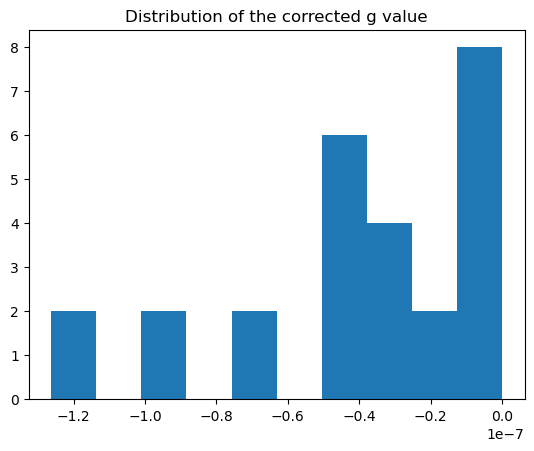

In [6]:
plt.title('Distribution of the corrected g value')
_ = plt.hist(df['GRAVCORR'] - df['GRAV (mgal)'])

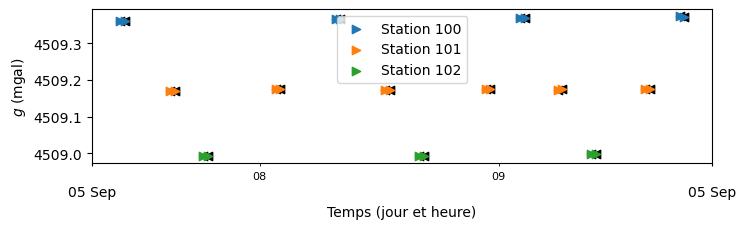

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(8, 2))

for station in df['STATION'].unique():
    plt.scatter(df.loc[df['STATION']==station, 'DATETIME'], df.loc[df['STATION']==station, 'GRAV (mgal)'], marker='<', c='black')
    plt.scatter(df.loc[df['STATION']==station, 'DATETIME'], df.loc[df['STATION']==station, 'GRAVCORR'], marker='>', label=f'Station {station}')
#plt.colorbar(im)
#plt.axhline(np.mean(df['GRAVCORR']), c='k')
plt.ylabel('$g$ (mgal)')
plt.xlabel('Temps (jour et heure)')
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.HourLocator(12))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d %b"))

ax.xaxis.set_minor_locator(mdates.HourLocator(np.arange(0, 24, 1)))
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%H"))

ax.tick_params(which="minor", axis="x", labelsize=8)
ax.tick_params(which="major", axis="x", pad=14, size=2)

ax.get_yaxis().get_major_formatter().set_useOffset(False)
plt.legend()
plt.savefig('figures/gravi_gradient_mesures.png')

In [8]:
model = LinearRegression()

x = df[['z']]
y = df['GRAVCORR']

# Train the model
model.fit(x, y)

# Evaluate the model
r2_score = model.score(x, y)
coef = model.coef_[0]

print(f"R-squared value: {r2_score} Coeff (gradient vertical) {coef}")

R-squared value: 0.999497094640318 Coeff (gradient vertical) -0.3244216012903931


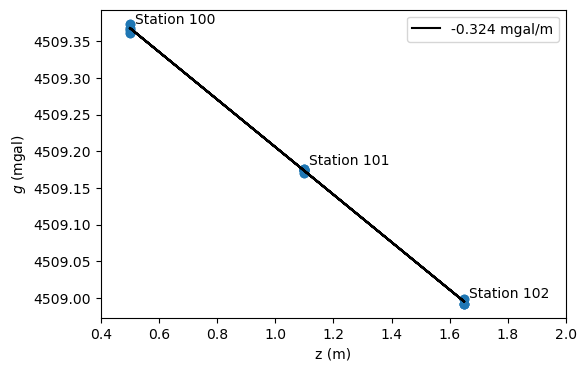

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

plt.plot(df['z'], model.predict(x), 'k-', label=f'{coef:.3f} mgal/m')
plt.scatter(df['z'], df['GRAVCORR'])
for station in df['STATION'].unique():
    z = np.mean(df.loc[df['STATION']==station, 'z'])
    g = np.mean(df.loc[df['STATION']==station, 'GRAVCORR'])
    plt.annotate(f'Station {station}', (z, g), xytext=(5, 5), textcoords="offset pixels")
ax.get_yaxis().get_major_formatter().set_useOffset(False)

plt.ylabel('$g$ (mgal)')
plt.xlabel('z (m)')

plt.xlim(0.4, 2)

plt.legend()
plt.savefig('figures/gravi_gradient_regression.png')